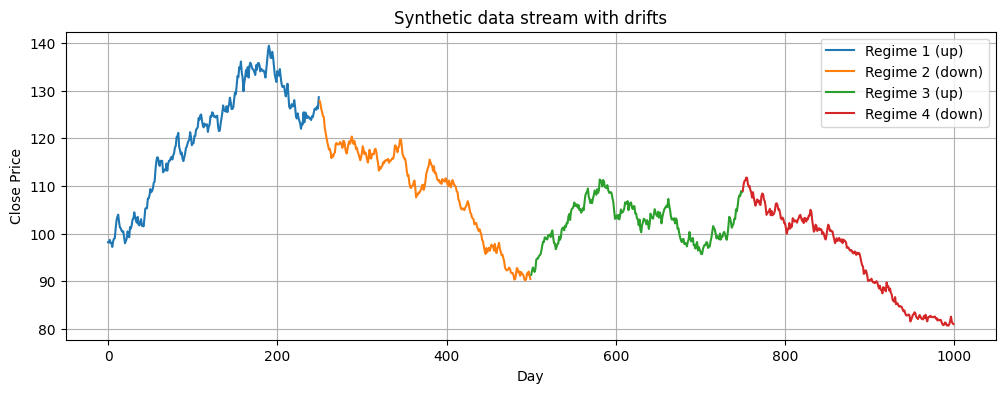

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def generate_synthetic_market_data(n_days=1000, n_drifts=3, start_price=100.0, seed=42):
    np.random.seed(seed)

    segment_length = n_days // (n_drifts + 1)

    closes = [start_price]
    returns = []
    regimes = []

    for i in range(n_drifts + 1):
        mu = np.random.choice([
            np.random.uniform(0.0005, 0.002),    # upward trend
            np.random.uniform(-0.002, -0.0005)   # downward trend
        ])
        sigma = np.random.uniform(0.005, 0.01)

        for _ in range(segment_length):
            ret = np.random.normal(mu, sigma)
            new_price = closes[-1] * (1 + ret)
            closes.append(new_price)
            returns.append(ret)
            regimes.append(f'{i+1}' + (' (up)' if mu > 0 else ' (down)'))

    closes = np.array(closes[1:])
    returns = np.array(returns)
    regimes = np.array(regimes[:n_days])

    # Generate OHLC around close
    gaps = np.random.normal(loc=0.0, scale=0.002, size=n_days)  # open gap
    open_prices = closes * (1 + gaps)

    high_spreads = np.abs(np.random.normal(loc=0.0015, scale=0.001, size=n_days))
    low_spreads = np.abs(np.random.normal(loc=0.0015, scale=0.001, size=n_days))

    highs = np.maximum(open_prices, closes) * (1 + high_spreads)
    lows = np.minimum(open_prices, closes) * (1 - low_spreads)

    df = pd.DataFrame({
        'open': open_prices,
        'high': highs,
        'low': lows,
        'close': closes,
        'return': returns,
        'regime': regimes
    })

    df['y'] = (df['close'].shift(-1) > df['close']).astype(int)

    return df.dropna().reset_index(drop=True)

df = generate_synthetic_market_data(n_days=1000, n_drifts=3, seed=2)

plt.figure(figsize=(12, 4))
for regime in df['regime'].unique():
    subset = df[df['regime'] == regime]
    plt.plot(subset.index, subset['close'], label=f"Regime {regime}")
plt.title("Synthetic data stream with drifts")
plt.xlabel("Day")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()